In [ ]:
from humpback import *

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [ ]:
def preprocess(
    data_array: np.ndarray,
    train_size: float,
    val_size: float,
    test_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    if train_size + val_size + test_size != 1:
        raise Exception("train_size + val_size + test_size != 1")

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [ ]:
class LSTM_stack(layers.Layer):
    """stacks of LSTM with dropout, follwed by dense layer"""

    def __init__(
        self,
        dropout_rate: float = 0.2
        ):
        super().__init__()

        self.lstm_1 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_2 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_3 = layers.LSTM(
            units=50,
            return_sequences=False,
            )

        self.dense_1 = layers.Dense(
            units=1
            )

        self.dropout_1 = layers.Dropout(dropout_rate)

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.dropout_1(x)
        x = self.lstm_2(inputs)
        x = self.dropout_1(x)
        x = self.lstm_3(inputs)
        x = self.dropout_1(x)
        return self.dense_1(x)

## Fetch Data

In [ ]:
client = connectBinanceAPI()

In [ ]:
symbol = 'BTCUSDT'
interval = '1h'

start_str = int(datetime(2020,1,1,0,0).timestamp() * 1000)
end_str   = int(datetime(2021,12,31,0,0).timestamp() * 1000)

train_size, val_size, test_size = 0.5, 0.2, 0.3

batch_size = 64
input_sequence_length = 20
forecast_horizon = 1
multi_horizon = False


In [ ]:
data_raw_df = getBinanceData(
    client=client,symbol=symbol,
    interval=interval,
    start_str=start_str,
    end_str=end_str
    )

In [ ]:
data_df = getReturn(data_raw_df, 'Close')
data_df = featureGeneration(data_df)
X_data_df , y_data_df  = getXy(data_df , 'Return')

In [ ]:
X_train_array, X_val_array, X_test_array = preprocess(X_data_df, train_size, val_size, test_size)
y_train_array, y_val_array, y_test_array = preprocess(y_data_df, train_size, val_size, test_size)

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
        X_train_array,
        y_train_array,
        sequence_length=input_sequence_length,
        shuffle=False,
    )

In [ ]:
val_dataset = keras.utils.timeseries_dataset_from_array(
        X_val_array,
        y_val_array,
        sequence_length=input_sequence_length,
        shuffle=False,
    ) 

In [ ]:
test_dataset = keras.utils.timeseries_dataset_from_array(
        X_test_array,
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
    ) 

## Model

In [ ]:
inputs  = keras.Input((
    input_sequence_length,
    X_train_array.shape[1]))
outputs = LSTM_stack()(inputs)
model   = keras.Model(inputs, outputs)

In [ ]:
optimizer = keras.optimizers.Adam()
loss      = keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer,loss=loss)

In [ ]:
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
    )

In [37]:
predictions = pd.DataFrame(model.predict(test_dataset), index=y_test_array.iloc[input_sequence_length-1:,].index)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


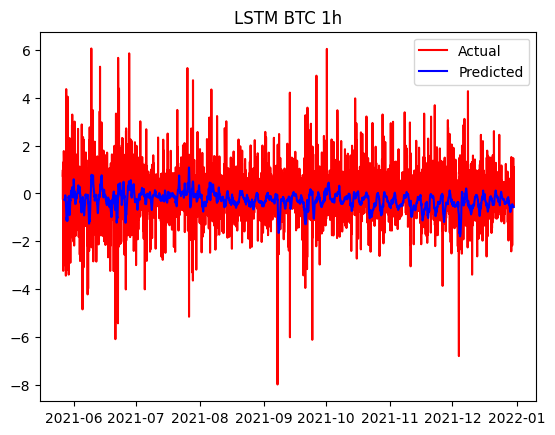

In [38]:
plt.plot(y_test_array, color='red', label='Actual')
plt.plot(predictions, color='blue', label='Predicted')
plt.title('LSTM BTC 1h')
plt.legend() 